In [3]:
# imports
from langchain import hub
import os, sys, getpass, bs4
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain.chat_models import init_chat_model
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# CREATE A .env FILE AND ADD ALL THE NECESSARY KEYS TO THAT FILE
load_dotenv()  # load environment variables from .env file

True

In [17]:
llm = init_chat_model("gpt-3.5-turbo", model_provider="openai")  # chat model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")  # embedding model
vector_store = InMemoryVectorStore(embeddings)  # vector-store

In [18]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
loader

In [19]:
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [20]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_splitter

In [21]:
all_splits = text_splitter.split_documents(docs)
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [30]:
_ = vector_store.add_documents(documents=all_splits)  # index chunks
_[:3]

['75a196dc-74f9-4b6d-9592-36a29cb53b7e',
 '65453e8f-6632-414a-a5de-c797cb45633a',
 '30691e3d-1d1e-427d-a16a-ef7b56b5fdd5']

In [23]:
prompt = hub.pull("rlm/rag-prompt")

In [32]:
message = prompt.invoke({
    "context": "(context goes here)", 
    "question": "(question goes here)"}
).to_messages()

assert len(message) == 1

In [34]:
from pprint import pprint
pprint(message[0].content)

('You are an assistant for question-answering tasks. Use the following pieces '
 "of retrieved context to answer the question. If you don't know the answer, "
 "just say that you don't know. Use three sentences maximum and keep the "
 'answer concise.\n'
 'Question: (question goes here) \n'
 'Context: (context goes here) \n'
 'Answer:')


In [35]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


In [36]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [37]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [ ]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

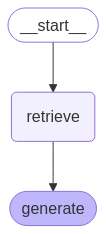

In [38]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex problem into smaller, more manageable tasks. It can be done using prompts, task-specific instructions, or human inputs to generate multiple thoughts per step in a tree structure. The search process for task decomposition can be BFS or DFS, with each state evaluated by a classifier or majority vote.


In [39]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='c0cd50c7-1921-426d-b472-f1f7518fff6e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='2aef127e-682e-4800-932a-4262755988d4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by expl